In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_v2_s
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
data_dir = "../../datasets/data21k"
batch_size = 32
num_classes = 5 
learning_rate = 0.001
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
       mean=[0.485, 0.456, 0.406], 
       std=[0.229, 0.224, 0.225]
    )
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = dataset.classes
print("Class Names:", class_names)

# Check data sample
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Class Names: ['CBB', 'CBSD', 'CGM', 'CH', 'CMD']
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [5]:
# Model Definition
model = efficientnet_v2_s(pretrained=True)  
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

c:\Users\nicho\anaconda3\envs\EV2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicho\anaconda3\envs\EV2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    
    total_epoch = [0]
    accuracy_list = [0]
    loss_list = [0]

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar for batches
        progress_bar = tqdm(train_loader, desc="Training")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

        total_epoch.append(epoch+1)
        accuracy_list.append(100 * correct/total)
        loss_list.append(running_loss/len(train_loader))

        validate_model(model, val_loader)
    

# Validation Loop
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Validation Accuracy: {100 * correct/total:.2f}%")

In [7]:
# Start Training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/50


Training: 100%|██████████| 535/535 [04:13<00:00,  2.11it/s, accuracy=76.9, loss=0.462]


Epoch [1/50], Loss: 0.6603, Accuracy: 76.91%


Validation: 100%|██████████| 134/134 [00:45<00:00,  2.91it/s]


Validation Accuracy: 83.25%
Epoch 2/50


Training: 100%|██████████| 535/535 [04:04<00:00,  2.18it/s, accuracy=82.7, loss=0.536]


Epoch [2/50], Loss: 0.4900, Accuracy: 82.74%


Validation: 100%|██████████| 134/134 [00:43<00:00,  3.08it/s]


Validation Accuracy: 82.22%
Epoch 3/50


Training: 100%|██████████| 535/535 [04:10<00:00,  2.13it/s, accuracy=85.8, loss=0.522]


Epoch [3/50], Loss: 0.4088, Accuracy: 85.76%


Validation: 100%|██████████| 134/134 [00:33<00:00,  3.98it/s]


Validation Accuracy: 84.37%
Epoch 4/50


Training: 100%|██████████| 535/535 [04:22<00:00,  2.04it/s, accuracy=87.9, loss=0.545] 


Epoch [4/50], Loss: 0.3474, Accuracy: 87.85%


Validation: 100%|██████████| 134/134 [00:45<00:00,  2.92it/s]


Validation Accuracy: 84.79%
Epoch 5/50


Training: 100%|██████████| 535/535 [03:28<00:00,  2.57it/s, accuracy=89.9, loss=0.208] 


Epoch [5/50], Loss: 0.2865, Accuracy: 89.88%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.25it/s]


Validation Accuracy: 62.90%
Epoch 6/50


Training: 100%|██████████| 535/535 [03:29<00:00,  2.56it/s, accuracy=92, loss=0.25]    


Epoch [6/50], Loss: 0.2263, Accuracy: 91.99%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.06it/s]


Validation Accuracy: 80.93%
Epoch 7/50


Training: 100%|██████████| 535/535 [03:29<00:00,  2.55it/s, accuracy=93.9, loss=0.286] 


Epoch [7/50], Loss: 0.1804, Accuracy: 93.91%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.14it/s]


Validation Accuracy: 51.94%
Epoch 8/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=94.7, loss=0.213] 


Epoch [8/50], Loss: 0.1542, Accuracy: 94.70%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.15it/s]


Validation Accuracy: 83.11%
Epoch 9/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=95.6, loss=0.175]  


Epoch [9/50], Loss: 0.1263, Accuracy: 95.57%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Validation Accuracy: 82.92%
Epoch 10/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=96.4, loss=0.103]  


Epoch [10/50], Loss: 0.1074, Accuracy: 96.35%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Validation Accuracy: 81.73%
Epoch 11/50


Training: 100%|██████████| 535/535 [03:27<00:00,  2.58it/s, accuracy=96.7, loss=0.02]   


Epoch [11/50], Loss: 0.0932, Accuracy: 96.68%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]


Validation Accuracy: 81.07%
Epoch 12/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=97.2, loss=0.0825] 


Epoch [12/50], Loss: 0.0788, Accuracy: 97.22%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]


Validation Accuracy: 84.21%
Epoch 13/50


Training: 100%|██████████| 535/535 [03:27<00:00,  2.57it/s, accuracy=97, loss=0.0127]   


Epoch [13/50], Loss: 0.0891, Accuracy: 97.01%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.13it/s]


Validation Accuracy: 83.74%
Epoch 14/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=97.7, loss=0.0165] 


Epoch [14/50], Loss: 0.0675, Accuracy: 97.70%


Validation: 100%|██████████| 134/134 [00:33<00:00,  4.05it/s]


Validation Accuracy: 82.78%
Epoch 15/50


Training: 100%|██████████| 535/535 [03:27<00:00,  2.58it/s, accuracy=97.7, loss=0.0202]  


Epoch [15/50], Loss: 0.0690, Accuracy: 97.67%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.06it/s]


Validation Accuracy: 82.64%
Epoch 16/50


Training: 100%|██████████| 535/535 [03:29<00:00,  2.55it/s, accuracy=97.6, loss=0.0223] 


Epoch [16/50], Loss: 0.0684, Accuracy: 97.57%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Validation Accuracy: 83.04%
Epoch 17/50


Training: 100%|██████████| 535/535 [03:27<00:00,  2.58it/s, accuracy=97.8, loss=0.0688]  


Epoch [17/50], Loss: 0.0617, Accuracy: 97.83%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


Validation Accuracy: 82.45%
Epoch 18/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.60it/s, accuracy=97.9, loss=0.0105]  


Epoch [18/50], Loss: 0.0641, Accuracy: 97.94%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]


Validation Accuracy: 82.43%
Epoch 19/50


Training: 100%|██████████| 535/535 [03:25<00:00,  2.60it/s, accuracy=98.2, loss=0.00376] 


Epoch [19/50], Loss: 0.0548, Accuracy: 98.17%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.11it/s]


Validation Accuracy: 82.43%
Epoch 20/50


Training: 100%|██████████| 535/535 [03:28<00:00,  2.56it/s, accuracy=98.3, loss=0.0976]  


Epoch [20/50], Loss: 0.0495, Accuracy: 98.32%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.17it/s]


Validation Accuracy: 82.73%
Epoch 21/50


Training: 100%|██████████| 535/535 [03:29<00:00,  2.55it/s, accuracy=98.2, loss=0.00974] 


Epoch [21/50], Loss: 0.0557, Accuracy: 98.24%


Validation: 100%|██████████| 134/134 [00:33<00:00,  4.04it/s]


Validation Accuracy: 82.31%
Epoch 22/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=98.2, loss=0.299]   


Epoch [22/50], Loss: 0.0536, Accuracy: 98.16%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]


Validation Accuracy: 82.66%
Epoch 23/50


Training: 100%|██████████| 535/535 [03:25<00:00,  2.60it/s, accuracy=98.2, loss=0.00915] 


Epoch [23/50], Loss: 0.0525, Accuracy: 98.23%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.21it/s]


Validation Accuracy: 83.08%
Epoch 24/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=98.7, loss=0.012]   


Epoch [24/50], Loss: 0.0424, Accuracy: 98.66%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


Validation Accuracy: 82.57%
Epoch 25/50


Training: 100%|██████████| 535/535 [03:27<00:00,  2.58it/s, accuracy=98.4, loss=0.0896]  


Epoch [25/50], Loss: 0.0462, Accuracy: 98.41%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


Validation Accuracy: 81.78%
Epoch 26/50


Training: 100%|██████████| 535/535 [03:25<00:00,  2.60it/s, accuracy=98.2, loss=0.00174] 


Epoch [26/50], Loss: 0.0550, Accuracy: 98.17%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]


Validation Accuracy: 82.76%
Epoch 27/50


Training: 100%|██████████| 535/535 [03:25<00:00,  2.60it/s, accuracy=98.7, loss=0.13]    


Epoch [27/50], Loss: 0.0380, Accuracy: 98.71%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


Validation Accuracy: 83.90%
Epoch 28/50


Training: 100%|██████████| 535/535 [03:25<00:00,  2.60it/s, accuracy=98.7, loss=0.0124]  


Epoch [28/50], Loss: 0.0398, Accuracy: 98.69%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]


Validation Accuracy: 83.29%
Epoch 29/50


Training: 100%|██████████| 535/535 [03:25<00:00,  2.60it/s, accuracy=98.7, loss=0.189]   


Epoch [29/50], Loss: 0.0409, Accuracy: 98.69%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.12it/s]


Validation Accuracy: 82.85%
Epoch 30/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=98.5, loss=0.0722]  


Epoch [30/50], Loss: 0.0438, Accuracy: 98.46%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]


Validation Accuracy: 83.41%
Epoch 31/50


Training: 100%|██████████| 535/535 [03:27<00:00,  2.58it/s, accuracy=99, loss=0.145]     


Epoch [31/50], Loss: 0.0297, Accuracy: 98.96%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


Validation Accuracy: 83.86%
Epoch 32/50


Training: 100%|██████████| 535/535 [03:27<00:00,  2.58it/s, accuracy=98.7, loss=0.0469]  


Epoch [32/50], Loss: 0.0405, Accuracy: 98.73%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.13it/s]


Validation Accuracy: 83.34%
Epoch 33/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.60it/s, accuracy=98.7, loss=0.00252] 


Epoch [33/50], Loss: 0.0397, Accuracy: 98.69%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]


Validation Accuracy: 83.11%
Epoch 34/50


Training: 100%|██████████| 535/535 [03:27<00:00,  2.58it/s, accuracy=98.8, loss=0.0227]  


Epoch [34/50], Loss: 0.0323, Accuracy: 98.84%


Validation: 100%|██████████| 134/134 [00:39<00:00,  3.42it/s]


Validation Accuracy: 82.90%
Epoch 35/50


Training: 100%|██████████| 535/535 [03:54<00:00,  2.28it/s, accuracy=98.7, loss=0.072]   


Epoch [35/50], Loss: 0.0411, Accuracy: 98.66%


Validation: 100%|██████████| 134/134 [00:39<00:00,  3.36it/s]


Validation Accuracy: 83.27%
Epoch 36/50


Training: 100%|██████████| 535/535 [03:58<00:00,  2.24it/s, accuracy=99, loss=0.0169]    


Epoch [36/50], Loss: 0.0289, Accuracy: 98.98%


Validation: 100%|██████████| 134/134 [00:39<00:00,  3.36it/s]


Validation Accuracy: 83.74%
Epoch 37/50


Training: 100%|██████████| 535/535 [03:58<00:00,  2.24it/s, accuracy=98.9, loss=0.00258] 


Epoch [37/50], Loss: 0.0305, Accuracy: 98.94%


Validation: 100%|██████████| 134/134 [00:40<00:00,  3.34it/s]


Validation Accuracy: 83.04%
Epoch 38/50


Training: 100%|██████████| 535/535 [03:58<00:00,  2.24it/s, accuracy=98.8, loss=0.00761] 


Epoch [38/50], Loss: 0.0355, Accuracy: 98.80%


Validation: 100%|██████████| 134/134 [00:40<00:00,  3.34it/s]


Validation Accuracy: 83.57%
Epoch 39/50


Training: 100%|██████████| 535/535 [03:35<00:00,  2.48it/s, accuracy=99, loss=0.0392]    


Epoch [39/50], Loss: 0.0296, Accuracy: 99.02%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.24it/s]


Validation Accuracy: 82.64%
Epoch 40/50


Training: 100%|██████████| 535/535 [03:23<00:00,  2.63it/s, accuracy=98.9, loss=0.0778]  


Epoch [40/50], Loss: 0.0324, Accuracy: 98.87%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.23it/s]


Validation Accuracy: 84.44%
Epoch 41/50


Training: 100%|██████████| 535/535 [03:23<00:00,  2.62it/s, accuracy=99.1, loss=0.0494]  


Epoch [41/50], Loss: 0.0294, Accuracy: 99.09%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.24it/s]


Validation Accuracy: 83.43%
Epoch 42/50


Training: 100%|██████████| 535/535 [03:23<00:00,  2.63it/s, accuracy=99, loss=0.0028]    


Epoch [42/50], Loss: 0.0283, Accuracy: 99.05%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.27it/s]


Validation Accuracy: 82.48%
Epoch 43/50


Training: 100%|██████████| 535/535 [03:23<00:00,  2.63it/s, accuracy=98.7, loss=0.00773] 


Epoch [43/50], Loss: 0.0370, Accuracy: 98.74%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.25it/s]


Validation Accuracy: 83.39%
Epoch 44/50


Training: 100%|██████████| 535/535 [03:24<00:00,  2.62it/s, accuracy=99, loss=0.0332]    


Epoch [44/50], Loss: 0.0286, Accuracy: 99.01%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.25it/s]


Validation Accuracy: 83.32%
Epoch 45/50


Training: 100%|██████████| 535/535 [03:23<00:00,  2.63it/s, accuracy=99.2, loss=0.0168]  


Epoch [45/50], Loss: 0.0260, Accuracy: 99.22%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.22it/s]


Validation Accuracy: 83.08%
Epoch 46/50


Training: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s, accuracy=99, loss=0.000638]  


Epoch [46/50], Loss: 0.0288, Accuracy: 99.02%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.24it/s]


Validation Accuracy: 82.87%
Epoch 47/50


Training: 100%|██████████| 535/535 [03:23<00:00,  2.62it/s, accuracy=99.1, loss=0.00629] 


Epoch [47/50], Loss: 0.0305, Accuracy: 99.07%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.22it/s]


Validation Accuracy: 83.27%
Epoch 48/50


Training: 100%|██████████| 535/535 [03:23<00:00,  2.63it/s, accuracy=99.2, loss=0.0043]  


Epoch [48/50], Loss: 0.0213, Accuracy: 99.22%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.25it/s]


Validation Accuracy: 82.24%
Epoch 49/50


Training: 100%|██████████| 535/535 [03:23<00:00,  2.63it/s, accuracy=98.9, loss=0.00649] 


Epoch [49/50], Loss: 0.0307, Accuracy: 98.88%


Validation: 100%|██████████| 134/134 [00:31<00:00,  4.27it/s]


Validation Accuracy: 83.53%
Epoch 50/50


Training: 100%|██████████| 535/535 [03:25<00:00,  2.60it/s, accuracy=99.3, loss=0.104]   


Epoch [50/50], Loss: 0.0239, Accuracy: 99.31%


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.11it/s]


Validation Accuracy: 83.60%


In [8]:
torch.save(model.state_dict(), "model_weights.pth")

In [10]:
torch.save(model, "model.pth")

In [6]:
torch.load("model.pth")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names)) 
model = model.to(device)

C:\Users\nicho\AppData\Local\Temp\ipykernel_29848\878427972.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("model.pth")


Validation: 100%|██████████| 134/134 [00:32<00:00,  4.07it/s]


Classification Report:
              precision    recall  f1-score   support

         CBB       0.03      0.16      0.06       230
        CBSD       0.12      0.10      0.11       425
         CGM       0.08      0.41      0.14       471
          CH       0.17      0.16      0.17       529
         CMD       0.26      0.00      0.00      2625

    accuracy                           0.09      4280
   macro avg       0.13      0.17      0.09      4280
weighted avg       0.20      0.09      0.05      4280



<Figure size 1000x700 with 0 Axes>

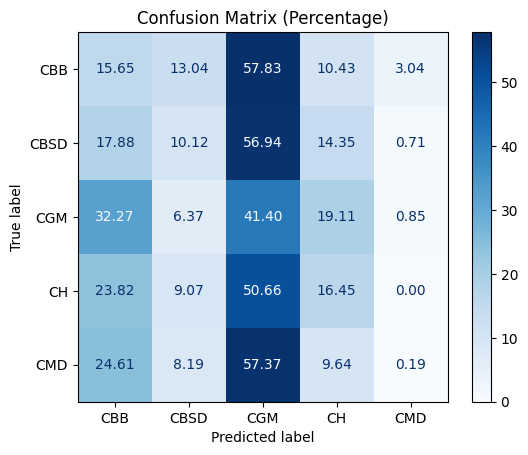

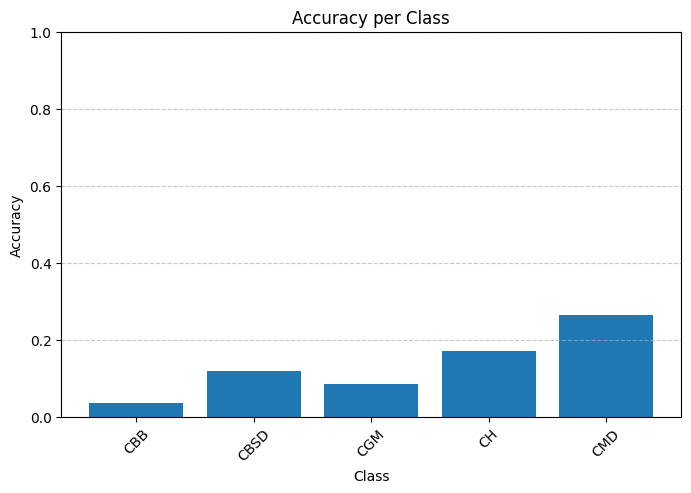

: 

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar for validation loop

def validate_model_with_visuals(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize to percentages
    
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Display Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot Confusion Matrix (percentage)
    plt.figure(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # Display as percentages with two decimals
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
    
    # Plot Accuracy per Class
    accuracies = [report[class_name]['precision'] for class_name in class_names]
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, accuracies)
    plt.ylim(0, 1)
    plt.title("Accuracy per Class")
    plt.ylabel("Accuracy")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

class_names = ['CBB', 'CBSD', 'CGM', 'CH', 'CMD'] 
validate_model_with_visuals(model, val_loader, class_names)
